In [2]:
# # this block of code imports graphical libraries for plotting graphs with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [3]:
# Libraries of functions need to be imported
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial import Delaunay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from scipy import linalg
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.decomposition import PCA

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [4]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

In [5]:
# this is the correct vectorized version
def Tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)

In [6]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

In [7]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Here I attempted to use the concrete data set, but have also included the cars.csv below.
data = pd.read_csv('drive/MyDrive/Data Sets/concrete.csv')

In [10]:
data

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [11]:
x = data.drop(columns=['strength']).values
y = data['strength'].values

In [23]:
def dist(u,v):
  D = []
  if len(v.shape)==1:
    v = v.reshape(1,-1)
  for rowj in v:
    D.append(np.sqrt(np.sum((u-rowj)**2,axis=1)))
  return np.array(D).T

In [12]:
def weight_function(u,v,kern=Gaussian,tau=0.5):
    return kern(dist(u,v)/(2*tau))

In [13]:
class Lowess:
    def __init__(self, kernel = Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau

    def fit(self, x, y):
        kernel = self.kernel
        tau = self.tau
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_
        lm = linear_model.Ridge(alpha=0.001)
        w = weight_function(x,x_new,self.kernel,self.tau)

        if np.isscalar(x_new):
          lm.fit(np.diag(w)@(x.reshape(-1,1)),np.diag(w)@(y.reshape(-1,1)))
          yest = lm.predict([[x_new]])[0][0]
        else:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[:,i])@x,np.diag(w[:,i])@y)
            yest_test[i] = lm.predict(x_new[i].reshape(1,-1))
        return yest_test

In [18]:
scale = MinMaxScaler()

In [19]:
model = Lowess(kernel=Epanechnikov,tau=0.02)

In [20]:
xscaled = scale.fit_transform(x)

In [21]:
model.fit(xscaled,y)

In [24]:
yhat = model.predict(xscaled)

In [25]:
mse(yhat,y)

5.069505109643628

In [51]:
# we can try the "elbow" approach for tunning tau
taus = np.arange(0.01, 0.25, 0.01)

In [52]:
mse_list = []
for tau in taus:
  model = Lowess(kernel=Gaussian,tau=tau)
  model.fit(xscaled,y)
  yhat = model.predict(xscaled)
  mse_list.append(mse(yhat,y))

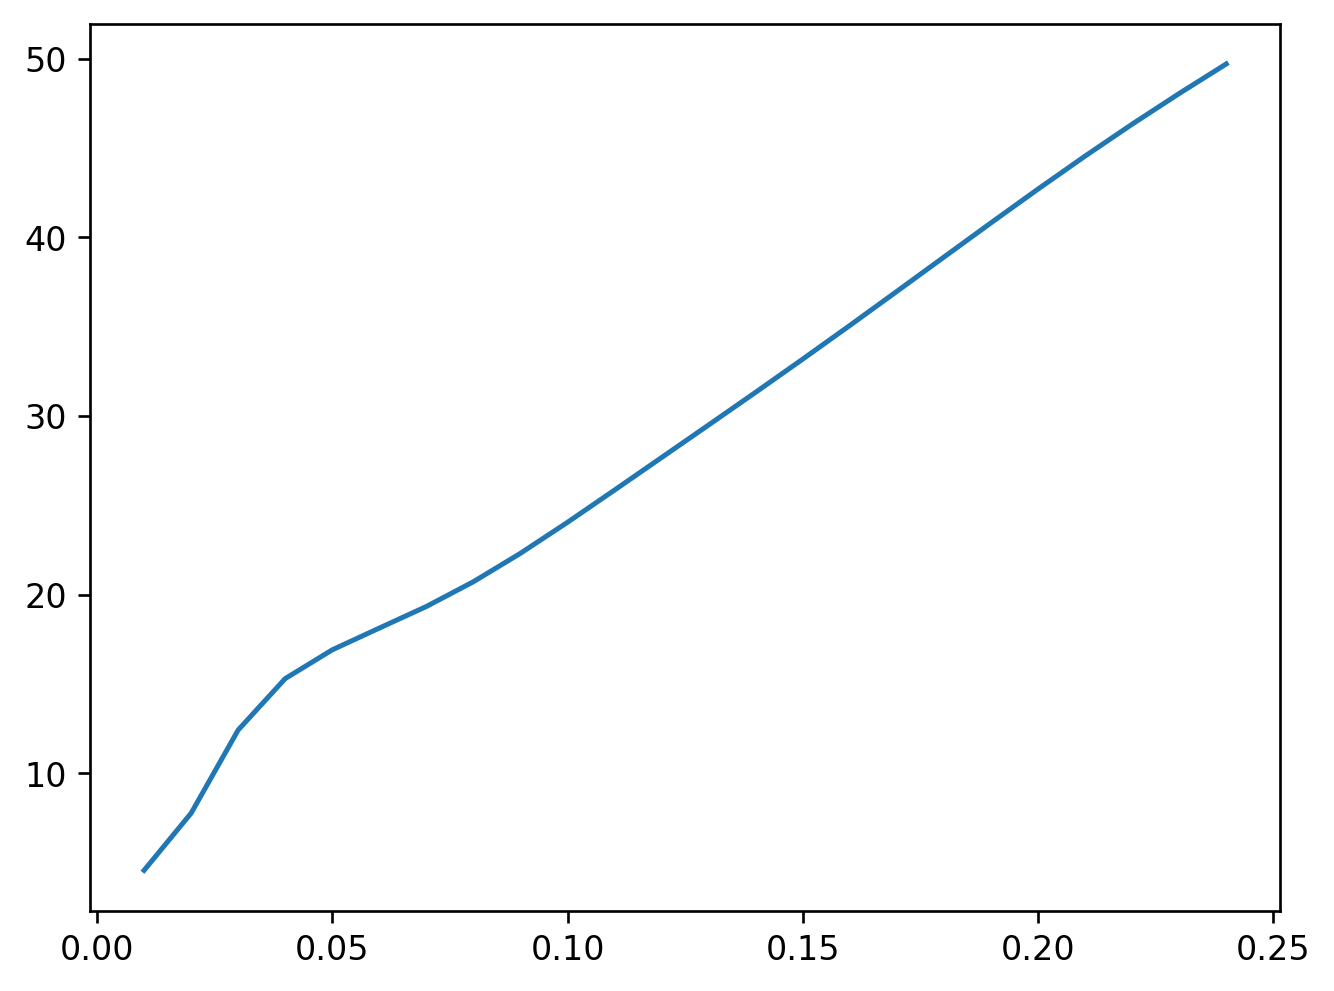

In [53]:
plt.plot(taus,mse_list)

In [68]:
mse_lwr = []
mse_rf = []
kf = KFold(n_splits=10,shuffle=True,random_state=1234)
model_rf = RandomForestRegressor(n_estimators=200,max_depth=7)
# model_lw = Lowess_AG_MD(f=1/3,iter=2,intercept=True)
model_lw = Lowess(kernel= Epanechnikov,tau=0.26)

for idxtrain, idxtest in kf.split(x):
  xtrain = x[idxtrain]
  ytrain = y[idxtrain]
  ytest = y[idxtest]
  xtest = x[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_lw.fit(xtrain,ytrain)
  yhat_lw = model_lw.predict(xtest)

  model_rf.fit(xtrain,ytrain)
  yhat_rf = model_rf.predict(xtest)

  mse_lwr.append(mse(ytest,yhat_lw))
  mse_rf.append(mse(ytest,yhat_rf))
print('The Cross-validated Mean Squared Error for Locally Weighted Regression is : '+str(np.mean(mse_lwr)))
print('The Cross-validated Mean Squared Error for Random Forest is : '+str(np.mean(mse_rf)))

The Cross-validated Mean Squared Error for Locally Weighted Regression is : 47.37352160481928
The Cross-validated Mean Squared Error for Random Forest is : 30.882302946795402


---
# Cars dataset

In [43]:
# Here I attempted to use the concrete data set, but have also included the cars.csv below.
data = pd.read_csv('drive/MyDrive/Data Sets/cars.csv')

In [ ]:
data

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [ ]:
x = data.drop(columns=['MPG']).values
y = data['MPG'].values

In [ ]:
scale = MinMaxScaler()

In [ ]:
model = Lowess(kernel=Epanechnikov,tau=0.02)

In [ ]:
xscaled = scale.fit_transform(x)

In [ ]:
model.fit(xscaled,y)

In [ ]:
yhat = model.predict(xscaled)

In [ ]:
mse(yhat,y)

5.069505109643628

In [ ]:
# we can try the "elbow" approach for tunning tau
taus = np.arange(0.01, 0.25, 0.01)

In [ ]:
mse_list = []
for tau in taus:
  model = Lowess(kernel=Gaussian,tau=tau)
  model.fit(xscaled,y)
  yhat = model.predict(xscaled)
  mse_list.append(mse(yhat,y))

In [ ]:
plt.plot(taus,mse_list)

In [ ]:
mse_lwr = []
mse_rf = []
kf = KFold(n_splits=10,shuffle=True,random_state=1234)
model_rf = RandomForestRegressor(n_estimators=200,max_depth=7)
# model_lw = Lowess_AG_MD(f=1/3,iter=2,intercept=True)
model_lw = Lowess(kernel= Epanechnikov,tau=0.14)

for idxtrain, idxtest in kf.split(x):
  xtrain = x[idxtrain]
  ytrain = y[idxtrain]
  ytest = y[idxtest]
  xtest = x[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_lw.fit(xtrain,ytrain)
  yhat_lw = model_lw.predict(xtest)

  model_rf.fit(xtrain,ytrain)
  yhat_rf = model_rf.predict(xtest)

  mse_lwr.append(mse(ytest,yhat_lw))
  mse_rf.append(mse(ytest,yhat_rf))
print('The Cross-validated Mean Squared Error for Locally Weighted Regression is : '+str(np.mean(mse_lwr)))
print('The Cross-validated Mean Squared Error for Random Forest is : '+str(np.mean(mse_rf)))